In this Notebook you will find 2 different implementations the convolution layer.

The first one is our own implementation, which sadly is involving the for loops you actually prevent us from using. Given the specifications of the problem, we have cosidered that the kernel and the actual image have to have the same number of channels (3rd dimension). 

You will also be able to see some tests with images with 1 and 3 color channels and (some of) the actual feature map that are derive from the convolution operation.

The second implementation, which you can find at the end of the document, is in no way an attempt to cheat. It has been generated with the help of ChatGPT, because, even though we spent quite a long time researching, and found out about AlphaTensor's algorithm, it was quite difficult to figure out and undrestand what was going on with those fourier trasformations which translate the original matrixes (e.g. the kernel and the image) into the frequency domain, which is a complex number space, and then back to the spatial domain.

To give just an slight sense of what we caught, those transformations, are converting the image encoded as a grid of pixels in the spatial domanin, into a sum of sinusoids in the frequency domain. Each of those frequencies corresponds to a specific pattern or teture in the image. Low frequencies correspond to smooth patterns (i.e. brightness), while high frequencies correspond to fine details (i.e. edges).

(These transforms are widely used in compression algorithms, as they allow to seggregate the high frequency components, which usually encode noise and the finest details from the image, and then compress the image by only storing the frequencies that are actually relevant to the image.)

Finally, the Fourier transforms for the image and the kernel are multiplied element-wise, and then the inverse Fourier transform is applied to the result, and voilà!, we obtain the convolution of the image and the kernel.

We must also mention that the extraction of the feature maps was quite fuzzy to undrestand as well, and the implementation is not ours, but we have looked into it and are able to undrestand what is going on as far as we can tell :).

Also, in the plotted images (feature maps), although they are quite gray as there is only 1 channel so we can't encode RGB, if you zoom in and squint your eyes you can see the cat :)

We hope you will enjoy our work, and we are looking forward to your feedback.

In [2]:
# Load mnist
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.datasets import mnist

# Split train into train and validation
(X_train, y_train), (X_val, y_val) = mnist.load_data()

# Normalize
X_train = X_train / 255
X_val = X_val / 255

# Reshape
X_train = X_train.reshape(-1, 28, 28, 1)
X_val = X_val.reshape(-1, 28, 28, 1)

# One hot encoding
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)

In [13]:
# This is our own implementation of the convolution

# Convolution function 
def convolve2d(image, kernel):
    # Check if the image is grayscale or not
    if image.shape[2] == 1:
        # Check that all kernels are grayscale
        for i in range(len(kernel)):
            if len(kernel[i].shape) == 3:
                raise Exception('Image is GS and kernels are not')
    if image.shape[2] == 3:
        # Check that all kernels are RGB
        for i in range(len(kernel)):
            if len(kernel[i].shape) == 2:
                raise Exception('Image is RGB and kernels are not')

# Apply the filters to the image
    post_filters = []
    for i in range(len(kernel)):
        # Create a new matrix for the post filter and initialize with zeros
        post_filter = np.zeros((image.shape[0] - kernel[i].shape[0] + 1, image.shape[1] - kernel[i].shape[1] + 1))
        # Undesired for loops and matrix multiplication
        for j in range(post_filter.shape[0]):
            for k in range(post_filter.shape[1]):
                post_filter[j, k] = np.sum(image[j:j + kernel[i].shape[0], k:k + kernel[i].shape[1]] * kernel[i]) # <- Matrix multiplication
                    # Here we could have used Strassen's algorithm to speed up the process, but the matrix sizes and the 
                    # complexity of the implementation makes it not worth it given cost difference
        
        # Checking the shape for debugging purposes
        #print ("post_filter shape: ") 
        #print(post_filter.shape)

        post_filters.append(post_filter)
        
    #return post_filters

# Get vertical and horizontal feature maps for each post filter
    feature_maps = []
    for i in range(len(post_filters)):
        
        # Erase last row and column if the shape is odd, it gives errors otherwise
        if post_filters[i].shape[0] % 2 != 0:
            post_filters[i] = post_filters[i][:-1, :]
        if post_filters[i].shape[1] % 2 != 0:
            post_filters[i] = post_filters[i][:, :-1]

        # Split the feature map into vertical and horizontal feature maps
        vertical_feature_map = post_filters[i][::2, :] - post_filters[i][1::2, :]
        horizontal_feature_map = post_filters[i][:, ::2] - post_filters[i][:, 1::2]
        feature_maps.append((vertical_feature_map,horizontal_feature_map))
    
    return feature_maps


In [14]:
x = convolve2d(X_train[0], [np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]]), np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])])

post_filter shape: 
(26, 26)
post_filter shape: 
(26, 26)


post_filter shape: 
(26, 26)
post_filter shape: 
(26, 26)


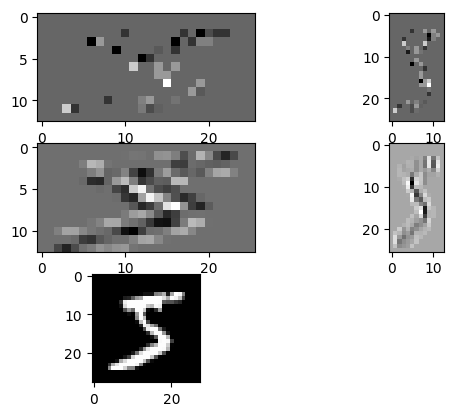

In [15]:
# Plot the vertical and horizontal feature maps for the first filter
x_train_0_post = convolve2d(X_train[0], [np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]]), np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])])

plt.subplot(3, 2, 1)
plt.imshow(x_train_0_post[0][0], cmap='gray')
plt.subplot(3, 2, 2)
plt.imshow(x_train_0_post[0][1], cmap='gray')
plt.subplot(3, 2, 3)
plt.imshow(x_train_0_post[1][0], cmap='gray')
plt.subplot(3, 2, 4)
plt.imshow(x_train_0_post[1][1], cmap='gray')
plt.subplot(3, 2, 5)
plt.imshow(X_train[0], cmap='gray')


post_filter shape: 
(1199, 1200)
post_filter shape: 
(1199, 1200)
post_filter shape: 
(1199, 1200)


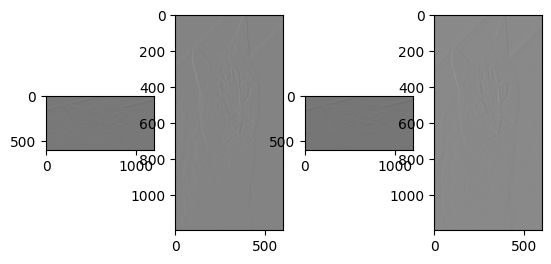

In [19]:
# load cat picture
from PIL import Image

img = Image.open('cat.jpeg')
cat = np.array(img) / 255

# rgb 3d filters
filter_r = np.array([[[0,0,1]]])
filter_g = np.array([[[0,1,0]]])
filter_b = np.array([[[1,0,0]]])

cat_post = convolve2d(cat, [filter_r, filter_g, filter_b])
# Plot the vertical and horizontal feature maps for the first filter
plt.subplot(1, 4, 1)
plt.imshow(cat_post[0][0], cmap='gray')
plt.subplot(1, 4, 2)
plt.imshow(cat_post[0][1], cmap='gray')
plt.subplot(1, 4, 3)
plt.imshow(cat_post[1][0], cmap='gray')
plt.subplot(1, 4, 4)
plt.imshow(cat_post[1][1], cmap='gray')

#plt.imshow(cat)

post_filter shape: 
(1197, 1198)
post_filter shape: 
(1197, 1198)
post_filter shape: 
(1197, 1198)


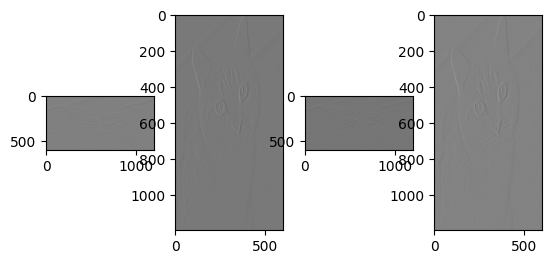

In [22]:
# 3x3x3 filters
filter_1 = np.array([[[1, 0, -1], [1, 0, -1], [1, 0, -1]], [[1, 1, 1], [0, 0, 0], [-1, -1, -1]], [[1, 1, 1], [1, 1, 1], [1, 1, 1]]])
filter_2 = np.array([[[1, 1, 1], [1, 1, 1], [1, 1, 1]], [[1, 0, -1], [1, 0, -1], [1, 0, -1]], [[1, 1, 1], [0, 0, 0], [-1, -1, -1]]])
filter_3 = np.array([[[1, 1, 1], [0, 0, 0], [-1, -1, -1]], [[1, 1, 1], [1, 1, 1], [1, 1, 1]], [[1, 0, -1], [1, 0, -1], [1, 0, -1]]])

cat_post_3x3x3 = convolve2d(cat, [filter_1, filter_2, filter_3])

plt.subplot(1, 4, 1)
plt.imshow(cat_post_3x3x3[0][0], cmap='gray')
plt.subplot(1, 4, 2)
plt.imshow(cat_post_3x3x3[0][1], cmap='gray')
plt.subplot(1, 4, 3)
plt.imshow(cat_post_3x3x3[1][0], cmap='gray')
plt.subplot(1, 4, 4)
plt.imshow(cat_post_3x3x3[1][1], cmap='gray')


In [23]:
cat_post_vertical, cat_post_horizontal = convolve2d(cat, [filter_1, filter_2, filter_3])[0]

post_filter shape: 
(1197, 1198)
post_filter shape: 
(1197, 1198)
post_filter shape: 
(1197, 1198)


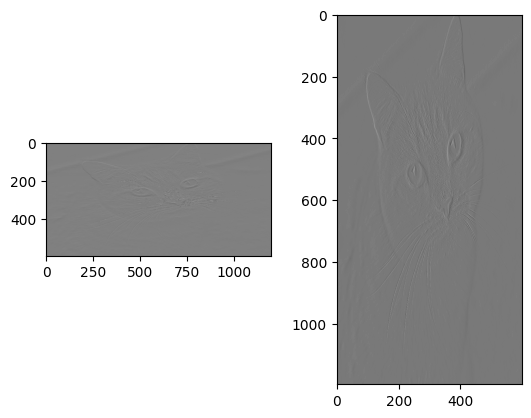

In [24]:
plt.subplot(1, 2, 1)
plt.imshow(cat_post_vertical, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(cat_post_horizontal, cmap='gray')

ChatGPT :)

In [ ]:
def convolve(image, kernel): # <- Here we assume that the kernel is a 2D array for simplicity purposes :)
    # get the dimensions of the image and kernel
    m, n, c = image.shape
    p, q = kernel.shape

    # pad the image and kernel to the same size
    padded_image = np.pad(image, ((0, p-1), (0, q-1), (0, 0)), mode='constant')
    padded_kernel = np.pad(kernel, ((m-p, m-p), (n-q, n-q)), mode='constant')

    # create alpha and beta matrices which will store the result of the FFT
    alpha = np.sqrt(m*n) * np.fft.fft2(padded_image, axes=(0, 1))
    beta = np.sqrt(m*n) * np.fft.fft2(padded_kernel, axes=(0, 1))

    # perform the convolution in frequency domain, which is basically a pointwise 
    # multiplication of the FFTs, and then take real part of the inverse FFT to get the result
    result = np.real(np.fft.ifft2(alpha * beta, axes=(0, 1)))

    # crop the result to remove the padding
    result = result[p-1:m, q-1:n]

    # combine the results for each channel
    if c == 1:
        return result
    else:
        # Here we are assuming that the image is RGB so we apply the same kernel to each channel, as  we are assuming the kernel is 2D
        return np.stack([convolve(image[:,:,i], kernel) for i in range(c)], axis=2)